In [3]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import SimpleITK as sitk
import tensorflow as tf
from tensorflow import keras
from keras.layers import AveragePooling3D

import time
import copy
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import os
import imageio
import pydicom as dicom
import pandas as pd
import sys

import SimpleITK
from scipy import ndimage as ndi
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import disk, dilation, binary_erosion, binary_closing
from skimage.filters import roberts, sobel
import cv2
from KEM_EXPE import *
from experiment_auxiliary import *
import re

sys.path.append('../')
sys.path.append('../Models/')

from utils import *
from GMM import *
from Kmeans import *
%matplotlib inline

In [4]:
depth = 99  # the depth th slice will be shown

path = '/database/datasets/Classics/LIDCdata/'  # LIDC dataset
patient_folders = os.listdir(path)
print(len(patient_folders))

# np.random.seed(609)
# index_list = np.random.randint(low=0, high=len(patient_folders), size=(3))
# index_list

158


In [5]:
index_list = [2, 19, 47]

In [6]:
for index in index_list:
    print(get_patient_folder(path, index))

/database/datasets/Classics/LIDCdata/LIDC-IDRI-0405/01-01-2000-NA-NA-51249/30078.000000-NA-51914/
/database/datasets/Classics/LIDCdata/LIDC-IDRI-0811/01-01-2000-1-NA-15517/30007.000000-NA-84692/
/database/datasets/Classics/LIDCdata/LIDC-IDRI-0875/01-01-2000-NA-NA-92135/30034.000000-NA-78531/


In [7]:
index = index_list[0]

In [8]:
## raw CT data folder
original_folder = get_patient_folder(path, index)

name = copy.copy(original_folder)
name = re.findall('LIDC-IDRI-[0-9]*', name)[0]

patient_folder = get_patient_folder(path, index)  # the patient's folder
# read in experiment data
experiment_data, slope, intercept = load_experiment_data_lidc(patient_folder)
print(experiment_data.shape)

(260, 512, 512)


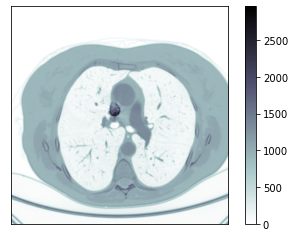

In [9]:
# show_slice(experiment_data[depth], None, False)
show_slice(experiment_data[depth], None, True)

# Lung Concentration

In [10]:
lung_threshold = -200

t1 = time.time()
concentrated_data = lung_concentration(experiment_data, lung_threshold, slope, intercept)
t2 = time.time()
print(f"lung concentration: {t2 - t1:.6f}")

lung concentration: 22.435134


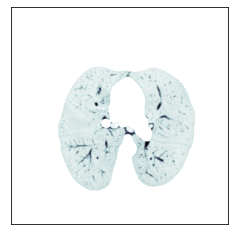

In [11]:
show_slice(concentrated_data[depth], None, False)
# show_slice(concentrated_data[depth], None, True)

In [12]:
# rescale the data
CT_min = concentrated_data.min()
CT_max = concentrated_data.max()
concentrated_data = (concentrated_data - CT_min) / (CT_max - CT_min)

In [13]:
CT_min, CT_max

(0.0, 3170.0)

In [14]:
shape = concentrated_data.shape
experiment_data = tf.cast(tf.convert_to_tensor(concentrated_data), tf.float32)
experiment_data = tf.reshape(experiment_data, (1,) + experiment_data.shape + (1,))

2024-01-31 12:31:42.410480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 12:31:42.987010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:9d:00.0, compute capability: 8.0


# KEM Algorithm

In [15]:
np.random.seed(0)
tf.random.set_seed(0)

In [16]:
Ch = 0.2217
sample_size = shape[0] * shape[1] * shape[2]
bandwidth_base = sample_size**(-1/7)
optimal_bandwidth = Ch * bandwidth_base
kernel_shape = (3, 3, 3)
# optimal_bandwidth = 10 / 512

In [17]:
# use all the data
training_ratio = 1
position_mask = np.random.binomial(n=1, p=training_ratio, size=experiment_data.shape)
position_mask = tf.convert_to_tensor(position_mask, dtype=tf.float32)
training_data = position_mask * experiment_data

In [18]:
t1 = time.time()
kem_pre = KEM_EXPE(K=3, shape=shape, 
                  training_data=training_data, 
                  position_mask=position_mask, 
                  kernel_shape=kernel_shape, 
                  bandwidth=optimal_bandwidth, 
                  kmeans_sample_ratio=1/100/training_ratio,
                  testing_data=None)
t2 = time.time()
print(f"{t2 - t1: .6f}")

From function(KEM_SIMU.__init__): training_data.shape: (1, 260, 512, 512, 1)
From function(__init__): Initialize mu via kmeans(with K=3)
Randomly pick 0.009995255103478064 positions for kmeans.
[0.23470031523736484, 0.052751714668469465, 8.2619436536948e-05]
From function(kmeans_initialization): rearanged centers: [0.23470031523736484, 0.052751714668469465, 8.2619436536948e-05]
From function(__init__): KMeans(with K=3) success, with time: 2.09 seconds
	centers: [2.3470032e-01 5.2751716e-02 8.2619437e-05]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 260, 512, 512, 1)
	pi_estimate: (3, 260, 512, 512, 1)
	mu_estimate: (3, 260, 512, 512, 1)
	sigma_estimate: (3, 260, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
 2.109750


In [19]:
t1 = time.time()
kem_pre.kem_algorithm(max_steps=20, epsilon=1e-4, smooth_parameter=1e-20)
t2 = time.time()
print(f"{t2 - t1: .6f}")

From function(kem_algorithm): Receive max_steps: 20.


2024-01-31 12:32:19.768078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


########################## STEP 0 ##########################
	 Current pik difference: 0.0438861
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0433669
	 Current mu difference: 0.0180923
	 Current sigma difference: 0.00934412
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.0708032.
---This iteration step costs 2.768 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.127862
From function(kem_algorithm): E step success.
From m_step: add smooth_parameter to sigma_estimate
	 Current pi difference: 0.127215
	 Current mu difference: 3.18461e-06
	 Current sigma difference: 0.0177289
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.144947.
---This iteration step costs 0.9031 seconds.---
########################## STEP 2 ##########################
	 Current pik difference: 0.0006035
From function(kem_algorithm): E step success.
From m_ste

- posterior probability:

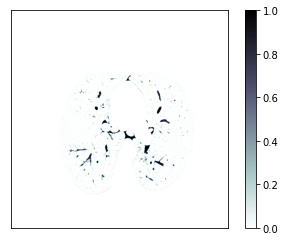

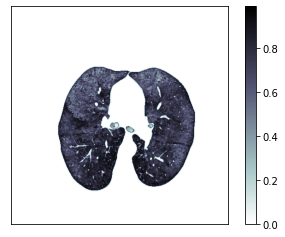

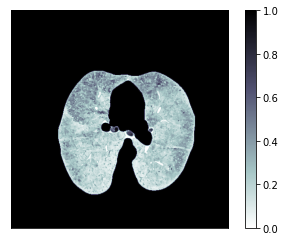

In [20]:
kem_pik_estimate = kem_pre.pik_estimate
for k in range(3):
    show_slice(kem_pik_estimate[k, depth])

## Generate synthetic responses by KEM method

In [21]:
mu = tf.squeeze(kem_pre.mu_estimate)
pi = tf.squeeze(kem_pre.pik_estimate)
sigma = tf.squeeze(kem_pre.sigma_estimate)

In [22]:
pi_max = tf.reduce_max(pi, axis=0)
pi_new = tf.cast(pi == pi_max, tf.float32)
pi_new.shape

TensorShape([3, 260, 512, 512])

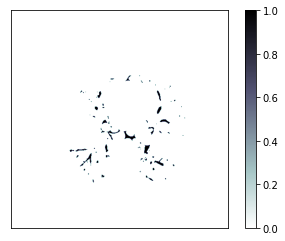

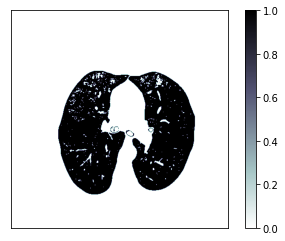

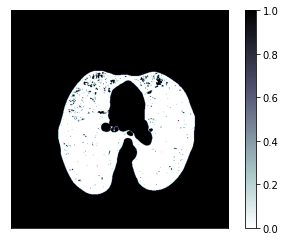

In [23]:
for k in range(3):
    show_slice(pi_new[k, depth])

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
import SimpleITK as sitk
import tensorflow as tf
from tensorflow import keras
from keras.layers import AveragePooling3D
import time
import copy
from sklearn.cluster import KMeans
import pandas as pd
import gc
from sklearn.linear_model import LinearRegression
import math
import tensorflow as tf
from multiprocessing import Process, Manager
import datetime
import sys
import csv
import os
from tensorflow.keras.utils import to_categorical

sys.path.append('../')
sys.path.append('../Models/')
sys.path.append('../KEM_simulation/')
from utils import *
from GMM import *
from Kmeans import *
from data_generate import *  # 参数生成文件
from KEM_SIMU import *  # KEM 类

%matplotlib inline

################ k = 0 ################
[0] tmp_data.max: 0.9803
[0] tmp_data.mean: 0.01198


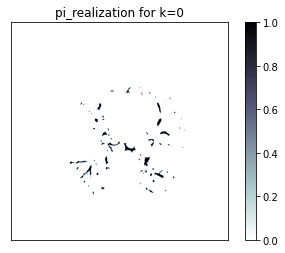

################ k = 1 ################
[1] tmp_data.max: 1.166
[1] tmp_data.mean: 0.009193


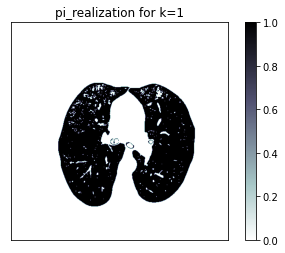

################ k = 2 ################
[2] tmp_data.max: 1.185
[2] tmp_data.mean: 0.008335


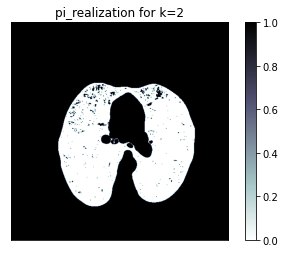

from function(generate_simulate_data_new_version): simulate_data.max=0.9803


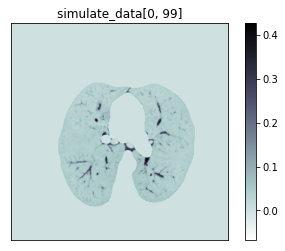

In [25]:
simulate_data, pi_realization = generate_simulate_data_new_version(pi_new, mu, sigma, seed=0, IsShow=True)

In [26]:
simu_min = tf.reduce_min(simulate_data)
simu_max = tf.reduce_max(simulate_data)

simulate_data = (simulate_data - simu_min) / (simu_max - simu_min)

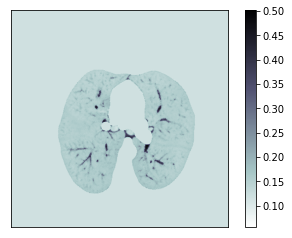

In [27]:
show_slice(simulate_data[0, depth])

In [54]:
output_folder = f"./3D Reconstruction/[(KEM_GT)]-{name}/" 

tmp = transfer_pi_to_dicom(pi_realization[0].numpy(), original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====recreate the folder at ./3D Reconstruction/[(KEM_GT)]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./3D Reconstruction/[(KEM_GT)]-LIDC-IDRI-0405/====


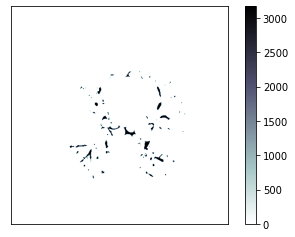

In [55]:
show_slice(tmp[depth])

In [28]:
np.random.seed(0)
tf.random.set_seed(0)

training_ratio = 1  # ratio of the voxel positions are used for training
# training_ratio = 1  # ratio of the voxel positions are used for training
# generate a mask, if =1 then are maintained as training data
position_mask = np.random.binomial(n=1, p=training_ratio, size=simulate_data.shape)
position_mask = tf.convert_to_tensor(position_mask, dtype=tf.float32)
training_data = position_mask * simulate_data
# if =0 then are maintained as training data
testing_data = (1 - position_mask) * simulate_data

In [29]:
position_mask.shape

TensorShape([1, 260, 512, 512, 1])

# $k$-means

In [30]:
kmeans_model = Kmeans(K=3,
                      shape=shape, 
                      training_data=training_data, 
                      position_mask=position_mask, 
                      kmeans_sample_ratio=1/100/training_ratio,
                      testing_data=None)

From function(__init__): Randomly pick 0.009995 data for kmeans.


In [31]:
kmeans_model.kmeans_algorithm(max_steps=20)

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1305: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


In [32]:
kmeans_model.mu_estimate

array([0.34725606, 0.16494176, 0.11765562], dtype=float32)

In [33]:
kmeans_labels = kmeans_model.predict_all_class()

(1, 260, 512, 512, 1)


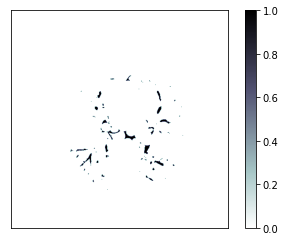

In [34]:
kmeans_class_results = tf.cast(kmeans_labels == 0, tf.float32)
show_slice(kmeans_class_results[0, depth])

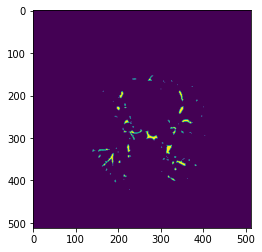

In [35]:
plt.imshow(kmeans_class_results[0, depth])

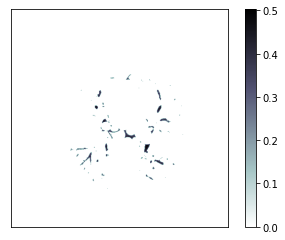

In [36]:
kmeans_results = training_data * tf.cast(kmeans_labels == 0, tf.float32) # 原来的代码
show_slice(kmeans_results[0, depth])

In [37]:
kmeans_result = kmeans_results[0].numpy()

In [68]:
output_folder = f"./3D Reconstruction/[kmeans_CTvalue(KEM)]-{name}/" #({datetime.date.today().strftime('%y%m%d')})

tmp = transfer_pi_to_dicom(kmeans_result, original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====recreate the folder at ./3D Reconstruction/[kmeans_CTvalue(KEM)]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./3D Reconstruction/[kmeans_CTvalue(KEM)]-LIDC-IDRI-0405/====


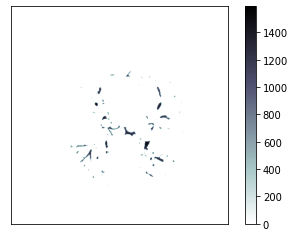

In [69]:
show_slice(tmp[depth])

# GMM

In [38]:
gmm_model = GMM(K=3, 
                shape=shape, 
                training_data=training_data, 
                position_mask=position_mask, 
                kmeans_sample_ratio=1/100/training_ratio,
                testing_data=None)

From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.009995 data for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 1.721 seconds
	centers: [0.3459517  0.16484788 0.11733711]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 260, 512, 512, 1)
	pi_estimate: (3, 1, 1, 1, 1)
	mu_estimate: (3, 1, 1, 1, 1)
	sigma_estimate: (3, 1, 1, 1, 1)


In [39]:
gmm_model.gmm_algorithm(max_steps=20, epsilon=1e-4, smooth_parameter=1e-20)
print()
print(gmm_model.mu_estimate)
print()

From function(gmm_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.0646541
From function(gmm_algorithm): E step success.
pi_estimator: [0.00624544 0.4179638  0.57541466]

mu_estimate: [0.3459517  0.16484788 0.11733711]
sigma_estimator: [0.07245746 0.0218181  0.01394341]
	 Current pi difference: 0.0575841
	 Current mu difference: 0.00049479
	 Current sigma difference: 0.000866212
From function(gmm_algorithm): M step success.
From function(gmm_algorithm): difference: 0.0589451.
---This iteration step costs 0.1174 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.0118272
From function(gmm_algorithm): E step success.
pi_estimator: [0.01080574 0.37657562 0.6137432 ]

mu_estimate: [0.33671704 0.1276974  0.12168819]
sigma_estimator: [0.07967535 0.02310627 0.00676188]
	 Current pi difference: 0.00106762
	 Current mu difference: 0.000770954
	 Current sigma difference: 3.

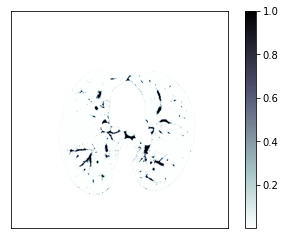

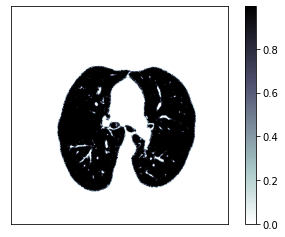

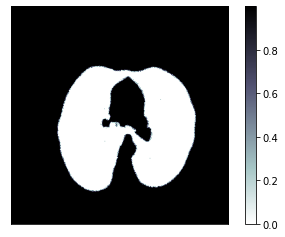

In [40]:
gmm_pik_estimate = gmm_model.pik_estimate
for k in range(3):
    show_slice(gmm_pik_estimate[k, depth])

In [41]:
gmm_result = tf.squeeze(gmm_model.pik_estimate)[0].numpy()

In [74]:
output_folder = f"./3D Reconstruction/[GMM_pik(KEM)]-{name}/" #({datetime.date.today().strftime('%y%m%d')})

tmp = transfer_pi_to_dicom(gmm_result, original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====recreate the folder at ./3D Reconstruction/[GMM_pik(KEM)]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./3D Reconstruction/[GMM_pik(KEM)]-LIDC-IDRI-0405/====


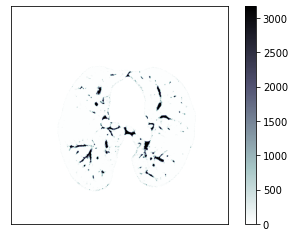

In [75]:
show_slice(tmp[depth])

# KEM Algorithm Again

In [42]:
np.random.seed(0)
tf.random.set_seed(0)

In [43]:
Ch = 0.2217
sample_size = shape[0] * shape[1] * shape[2]
bandwidth_base = sample_size**(-1/7)
optimal_bandwidth = Ch * bandwidth_base
kernel_shape = (5, 5, 5)

In [44]:
t1 = time.time()
kem_cv = KEM_EXPE(K=3, shape=shape, 
                  training_data=training_data, 
                  position_mask=position_mask, 
                  kernel_shape=kernel_shape, 
                  bandwidth=optimal_bandwidth, 
                  kmeans_sample_ratio=1/100/training_ratio,
                  testing_data=None)
t2 = time.time()
print(f"{t2 - t1: .6f}")

From function(KEM_SIMU.__init__): training_data.shape: (1, 260, 512, 512, 1)
From function(__init__): Initialize mu via kmeans(with K=3)
Randomly pick 0.009993479802058293 positions for kmeans.
[0.34697457333405674, 0.16497433753071422, 0.11733651729409349]
From function(kmeans_initialization): rearanged centers: [0.34697457333405674, 0.16497433753071422, 0.11733651729409349]
From function(__init__): KMeans(with K=3) success, with time: 1.72 seconds
	centers: [0.34697458 0.16497433 0.11733652]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 260, 512, 512, 1)
	pi_estimate: (3, 260, 512, 512, 1)
	mu_estimate: (3, 260, 512, 512, 1)
	sigma_estimate: (3, 260, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (5, 5, 5, 1, 1)
 1.734334


In [45]:
t1 = time.time()
kem_cv.kem_algorithm(max_steps=20, epsilon=1e-4, smooth_parameter=1e-20)
t2 = time.time()
print(f"{t2 - t1: .6f}")

From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.0427384
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0420306
	 Current mu difference: 0.017128
	 Current sigma difference: 0.00908345
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: 0.068242.
---This iteration step costs 6.913 seconds.---
########################## STEP 1 ##########################
	 Current pik difference: 0.12943
From function(kem_algorithm): E step success.
From m_step: add smooth_parameter to sigma_estimate
	 Current pi difference: 0.128337
	 Current mu difference: 6.8484e-06
	 Current sigma difference: nan
From function(kem_algorithm): M step success.
From function(kem_algorithm): difference: nan.
---This iteration step costs 2.081 seconds.---
 13.036583


- posterior probability:

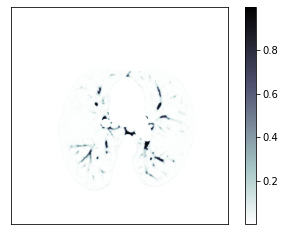

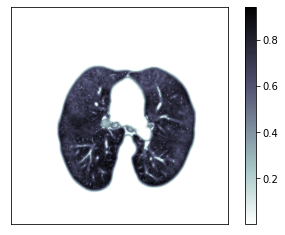

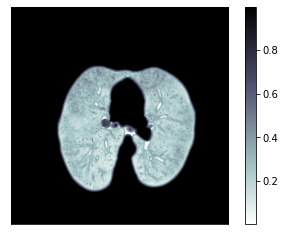

In [46]:
kem_pik_estimate = kem_cv.pik_estimate
for k in range(3):
    show_slice(kem_pik_estimate[k, depth])

In [47]:
kem_result = tf.squeeze(kem_pik_estimate)[0].numpy()

In [82]:
output_folder = f"./3D Reconstruction/[KEM_pik(KEM)]-{name}/" 

tmp = transfer_pi_to_dicom(kem_result, original_folder, output_folder, 
                           truncate_threshold=None,
                           CT_min=CT_min, CT_max=CT_max)

====recreate the folder at ./3D Reconstruction/[KEM_pik(KEM)]-LIDC-IDRI-0405/====
====truncate_threshold=None, thus no truncation is made====
====change the pi range to (0.0, 3170.0)====
====read the original dicom files and prepare to replace the pixel_array====
dcm_files length: 260
====successfully save the dicom files at ./3D Reconstruction/[KEM_pik(KEM)]-LIDC-IDRI-0405/====


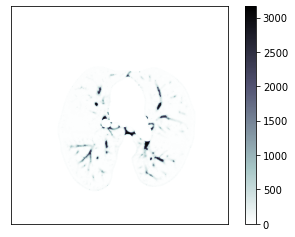

In [83]:
show_slice(tmp[depth])